In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define Gridworld Environment
class Gridworld:
    def __init__(self, size=5, start=(0, 0), goal=(4, 4), obstacles=[(2, 2), (3, 3)]):
        self.size = size # size of grid
        self.start = start # starting position of the agent
        self.goal = goal # goal position that the agent aims to reach
        self.obstacles = obstacles # List of grid postions that the agent can't move
        self.state = start

    def reset(self): # reset the environment to the initial state
        self.state = self.start # store the current postion of the agent
        return self.state

    def step(self, action):
        x, y = self.state
        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self.size - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self.size - 1, y + 1)

        new_state = (x, y) # update the environment based on the agent's action.
        if new_state in self.obstacles:
            reward = -5  # Penalty for hitting obstacle
            new_state = self.state  # Stay in the same place
        elif new_state == self.goal:
            reward = 10  # Reward for reaching the goal
        else:
            reward = -1  # Penalty for each step
        self.state = new_state
        done = new_state == self.goal
        return new_state, reward, done

    def get_state_space(self):
        return [(i, j) for i in range(self.size) for j in range(self.size)]


In [3]:
# Q-learning Algorithm
class QLearningAgent:
    def __init__(self, env, alpha=0.1,
                 gamma=0.9, epsilon=1.0,
                 epsilon_decay=0.995,
                 min_epsilon=0.01,
                 episodes=1000):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.episodes = episodes
        self.q_table = self._initialize_q_table()

    def _initialize_q_table(self):
        states = self.env.get_state_space()
        return {state: np.zeros(4) for state in states}  # 4 actions (Up, Down, Left, Right)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(4)  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit best action

    def train(self):
        rewards_per_episode = []
        for episode in range(self.episodes):
            state = self.env.reset()
            total_reward = 0
            done = False

            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)

                # Q-value update using Bellman equation
                self.q_table[state][action] = self.q_table[state][action] + \
                    self.alpha * (reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state][action])

                state = next_state
                total_reward += reward

            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            rewards_per_episode.append(total_reward)

        return rewards_per_episode

    def get_policy(self):
        policy = {}
        for state in self.q_table:
            policy[state] = np.argmax(self.q_table[state])
        return policy


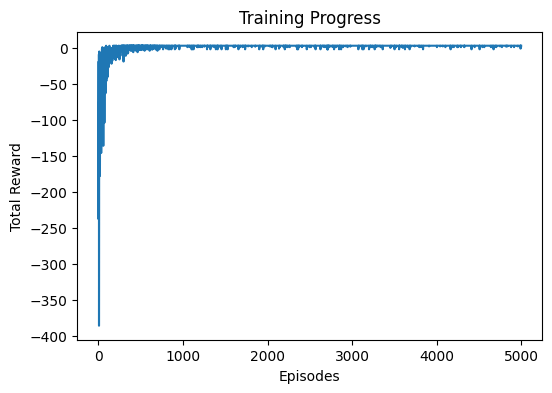

In [4]:
# Training and Evaluation
env = Gridworld()
agent = QLearningAgent(env, episodes=5000)
rewards = agent.train()
policy = agent.get_policy()

# Visualization: Training Progress
plt.figure(figsize=(6,4))
plt.plot(rewards)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Training Progress")
plt.show()

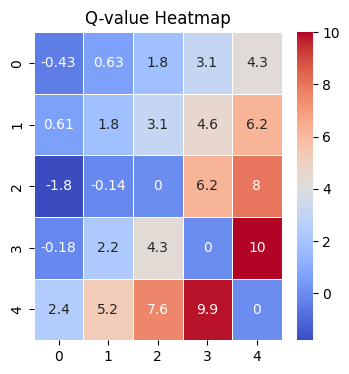

In [5]:
# Visualization: Heatmap of Q-values
q_values_matrix = np.zeros((env.size, env.size))
for state, actions in agent.q_table.items():
    q_values_matrix[state] = np.max(actions)

plt.figure(figsize=(4,4))
sns.heatmap(q_values_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Q-value Heatmap")
plt.show()

In [8]:
# Visualization: Policy Map
action_symbols = {0: "↑", 1: "↓", 2: "←", 3: "→"}
policy_grid = np.full((env.size, env.size), " ", dtype=str)
for state, action in policy.items():
    policy_grid[state] = action_symbols[action]

In [9]:
print("Policy Visualization:")
for row in policy_grid:
    print(" ".join(row))

Policy Visualization:
→ → ↓ ↓ ↓
→ → → ↓ ↓
↓ ↓ ↑ → ↓
↓ ↓ ↓ ↑ ↓
→ → → → ↑
